# Packages

In [1]:
#!pip install torchmetrics --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

Setting ds_accelerator to cuda (auto detect)


2023-09-23 19:12:27.560511: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 19:12:28.197718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 25
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [7]:
tokenizer = get_tokenizer("moses")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

In [9]:

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2222445
Valid Tokens:  243937
Test Tokens:  279249
Total number of tokens: 2745631


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 33264


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:

train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, (h,c) = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, (h,c) = self.rnn2(output,(c,h))
    output = self.dropout2(output)
    
    output, (h,c) = self.rnn3(output,(c,h))
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 39.309264



H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 3556/3556 [03:52<00:00, 15.30batch/s, loss=5.98, perplexity=550]    


Valid: Loss = 5.139 Perplexity= 182.4, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 3556/3556 [03:53<00:00, 15.26batch/s, loss=5.27, perplexity=206]


Valid: Loss = 4.519 Perplexity= 97.34, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 3556/3556 [03:52<00:00, 15.26batch/s, loss=4.61, perplexity=107]


Valid: Loss = 3.917 Perplexity= 53.23, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 3556/3556 [03:49<00:00, 15.48batch/s, loss=4.1, perplexity=63.2] 


Valid: Loss = 3.516 Perplexity= 35.46, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 3556/3556 [03:47<00:00, 15.63batch/s, loss=3.7, perplexity=42.5] 


Valid: Loss = 3.179 Perplexity= 25.26, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 3556/3556 [03:47<00:00, 15.63batch/s, loss=3.39, perplexity=30.9]


Valid: Loss = 2.931 Perplexity= 19.64, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 3556/3556 [03:45<00:00, 15.78batch/s, loss=3.12, perplexity=23.7]


Valid: Loss = 2.718 Perplexity= 15.85, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 3556/3556 [02:17<00:00, 25.79batch/s, loss=2.9, perplexity=18.9] 


Valid: Loss = 2.538 Perplexity= 13.19, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 3556/3556 [03:10<00:00, 18.64batch/s, loss=2.7, perplexity=15.4] 


Valid: Loss = 2.361 Perplexity= 11.01, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 3556/3556 [03:52<00:00, 15.31batch/s, loss=2.52, perplexity=12.9]


Valid: Loss = 2.228 Perplexity= 9.637, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 3556/3556 [03:52<00:00, 15.28batch/s, loss=2.36, perplexity=10.9]


Valid: Loss = 2.103 Perplexity= 8.483, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 3556/3556 [03:51<00:00, 15.35batch/s, loss=2.21, perplexity=9.41]


Valid: Loss = 1.965 Perplexity= 7.375, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 3556/3556 [03:52<00:00, 15.32batch/s, loss=2.09, perplexity=8.29]


Valid: Loss = 1.853 Perplexity= 6.584, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 3556/3556 [03:52<00:00, 15.31batch/s, loss=1.99, perplexity=7.49]


Valid: Loss = 1.922 Perplexity= 7.057, LR = 0.5



Epoch 14: 100%|██████████| 3556/3556 [03:53<00:00, 15.22batch/s, loss=1.65, perplexity=5.38]


Valid: Loss = 1.494 Perplexity= 4.576, LR = 0.25
Model Saved!



Epoch 15: 100%|██████████| 3556/3556 [03:54<00:00, 15.14batch/s, loss=1.51, perplexity=4.63]


Valid: Loss = 1.421 Perplexity= 4.249, LR = 0.25
Model Saved!



Epoch 16: 100%|██████████| 3556/3556 [03:53<00:00, 15.22batch/s, loss=1.44, perplexity=4.29]


Valid: Loss = 1.375 Perplexity= 4.051, LR = 0.25
Model Saved!



Epoch 17: 100%|██████████| 3556/3556 [03:50<00:00, 15.40batch/s, loss=1.38, perplexity=4.04]


Valid: Loss = 1.337 Perplexity= 3.895, LR = 0.25
Model Saved!



Epoch 18: 100%|██████████| 3556/3556 [03:50<00:00, 15.43batch/s, loss=1.32, perplexity=3.82]


Valid: Loss = 1.291 Perplexity= 3.718, LR = 0.25
Model Saved!



Epoch 19: 100%|██████████| 3556/3556 [03:50<00:00, 15.45batch/s, loss=1.28, perplexity=3.65]


Valid: Loss = 1.235 Perplexity= 3.513, LR = 0.25
Model Saved!



Epoch 20: 100%|██████████| 3556/3556 [03:51<00:00, 15.36batch/s, loss=1.23, perplexity=3.47]


Valid: Loss = 1.221 Perplexity= 3.459, LR = 0.25
Model Saved!



Epoch 21: 100%|██████████| 3556/3556 [03:52<00:00, 15.26batch/s, loss=1.19, perplexity=3.33]


Valid: Loss = 1.18 Perplexity= 3.321, LR = 0.25
Model Saved!



Epoch 22: 100%|██████████| 3556/3556 [03:54<00:00, 15.17batch/s, loss=1.15, perplexity=3.21]


Valid: Loss = 1.149 Perplexity= 3.218, LR = 0.25
Model Saved!



Epoch 23: 100%|██████████| 3556/3556 [04:39<00:00, 12.71batch/s, loss=1.11, perplexity=3.08]


Valid: Loss = 1.123 Perplexity= 3.133, LR = 0.25
Model Saved!



Epoch 24: 100%|██████████| 3556/3556 [05:23<00:00, 10.98batch/s, loss=1.08, perplexity=2.97]


Valid: Loss = 1.09 Perplexity= 3.03, LR = 0.25
Model Saved!



Epoch 25: 100%|██████████| 3556/3556 [05:25<00:00, 10.93batch/s, loss=1.04, perplexity=2.85]


Valid: Loss = 1.058 Perplexity= 2.931, LR = 0.25
Model Saved!



Epoch 26: 100%|██████████| 3556/3556 [05:25<00:00, 10.94batch/s, loss=1.01, perplexity=2.77]


Valid: Loss = 1.059 Perplexity= 2.936, LR = 0.25



Epoch 27: 100%|██████████| 3556/3556 [05:25<00:00, 10.92batch/s, loss=0.824, perplexity=2.3] 


Valid: Loss = 0.8756 Perplexity= 2.435, LR = 0.125
Model Saved!



Epoch 28: 100%|██████████| 3556/3556 [05:25<00:00, 10.92batch/s, loss=0.763, perplexity=2.16]


Valid: Loss = 0.8508 Perplexity= 2.375, LR = 0.125
Model Saved!



Epoch 29: 100%|██████████| 3556/3556 [05:23<00:00, 11.00batch/s, loss=0.739, perplexity=2.11]


Valid: Loss = 0.8387 Perplexity= 2.345, LR = 0.125
Model Saved!



Epoch 30: 100%|██████████| 3556/3556 [05:09<00:00, 11.49batch/s, loss=0.724, perplexity=2.08]


Valid: Loss = 0.8191 Perplexity= 2.298, LR = 0.125
Model Saved!



Epoch 31: 100%|██████████| 3556/3556 [05:03<00:00, 11.72batch/s, loss=0.711, perplexity=2.05]


Valid: Loss = 0.8105 Perplexity= 2.277, LR = 0.125
Model Saved!



Epoch 32: 100%|██████████| 3556/3556 [05:14<00:00, 11.30batch/s, loss=0.7, perplexity=2.02]  


Valid: Loss = 0.7999 Perplexity= 2.253, LR = 0.125
Model Saved!



Epoch 33: 100%|██████████| 3556/3556 [04:54<00:00, 12.06batch/s, loss=0.692, perplexity=2.01]


Valid: Loss = 0.8057 Perplexity= 2.267, LR = 0.125



Epoch 34: 100%|██████████| 3556/3556 [03:53<00:00, 15.20batch/s, loss=0.619, perplexity=1.87]


Valid: Loss = 0.7266 Perplexity= 2.091, LR = 0.0625
Model Saved!



Epoch 35: 100%|██████████| 3556/3556 [03:38<00:00, 16.25batch/s, loss=0.595, perplexity=1.82]


Valid: Loss = 0.7155 Perplexity= 2.068, LR = 0.0625
Model Saved!



Epoch 36: 100%|██████████| 3556/3556 [02:17<00:00, 25.78batch/s, loss=0.584, perplexity=1.8] 


Valid: Loss = 0.7093 Perplexity= 2.054, LR = 0.0625
Model Saved!



Epoch 37: 100%|██████████| 3556/3556 [03:43<00:00, 15.88batch/s, loss=0.576, perplexity=1.79]


Valid: Loss = 0.703 Perplexity= 2.041, LR = 0.0625
Model Saved!



Epoch 38: 100%|██████████| 3556/3556 [03:55<00:00, 15.10batch/s, loss=0.57, perplexity=1.78] 


Valid: Loss = 0.6967 Perplexity= 2.028, LR = 0.0625
Model Saved!



Epoch 39: 100%|██████████| 3556/3556 [03:55<00:00, 15.11batch/s, loss=0.564, perplexity=1.76]


Valid: Loss = 0.695 Perplexity= 2.024, LR = 0.0625
Model Saved!



Epoch 40: 100%|██████████| 3556/3556 [03:56<00:00, 15.06batch/s, loss=0.558, perplexity=1.75]


Valid: Loss = 0.6899 Perplexity= 2.014, LR = 0.0625
Model Saved!



Epoch 41: 100%|██████████| 3556/3556 [03:54<00:00, 15.19batch/s, loss=0.564, perplexity=1.77]


Valid: Loss = 0.6923 Perplexity= 2.019, LR = 0.0625



Epoch 42: 100%|██████████| 3556/3556 [03:55<00:00, 15.07batch/s, loss=0.526, perplexity=1.7] 


Valid: Loss = 0.6548 Perplexity= 1.943, LR = 0.03125
Model Saved!



Epoch 43: 100%|██████████| 3556/3556 [03:54<00:00, 15.19batch/s, loss=0.514, perplexity=1.68]


Valid: Loss = 0.65 Perplexity= 1.934, LR = 0.03125
Model Saved!



Epoch 44: 100%|██████████| 3556/3556 [03:55<00:00, 15.11batch/s, loss=0.509, perplexity=1.67]


Valid: Loss = 0.6458 Perplexity= 1.925, LR = 0.03125
Model Saved!



Epoch 45: 100%|██████████| 3556/3556 [03:54<00:00, 15.17batch/s, loss=0.504, perplexity=1.66]


Valid: Loss = 0.6432 Perplexity= 1.92, LR = 0.03125
Model Saved!



Epoch 46: 100%|██████████| 3556/3556 [03:55<00:00, 15.12batch/s, loss=0.501, perplexity=1.66]


Valid: Loss = 0.6391 Perplexity= 1.912, LR = 0.03125
Model Saved!



Epoch 47: 100%|██████████| 3556/3556 [03:46<00:00, 15.73batch/s, loss=0.497, perplexity=1.65]


Valid: Loss = 0.6362 Perplexity= 1.907, LR = 0.03125
Model Saved!



Epoch 48: 100%|██████████| 3556/3556 [03:40<00:00, 16.12batch/s, loss=0.494, perplexity=1.64]


Valid: Loss = 0.633 Perplexity= 1.9, LR = 0.03125
Model Saved!



Epoch 49: 100%|██████████| 3556/3556 [03:40<00:00, 16.12batch/s, loss=0.491, perplexity=1.64]


Valid: Loss = 0.6335 Perplexity= 1.901, LR = 0.03125



Epoch 50: 100%|██████████| 3556/3556 [03:40<00:00, 16.14batch/s, loss=0.483, perplexity=1.63]


Valid: Loss = 0.6186 Perplexity= 1.873, LR = 0.015625
Model Saved!



Epoch 51: 100%|██████████| 3556/3556 [03:41<00:00, 16.04batch/s, loss=0.477, perplexity=1.62]


Valid: Loss = 0.6153 Perplexity= 1.866, LR = 0.015625
Model Saved!



Epoch 52: 100%|██████████| 3556/3556 [03:40<00:00, 16.13batch/s, loss=0.473, perplexity=1.61]


Valid: Loss = 0.613 Perplexity= 1.862, LR = 0.015625
Model Saved!



Epoch 53: 100%|██████████| 3556/3556 [03:44<00:00, 15.87batch/s, loss=0.47, perplexity=1.61] 


Valid: Loss = 0.6109 Perplexity= 1.858, LR = 0.015625
Model Saved!



Epoch 54: 100%|██████████| 3556/3556 [03:56<00:00, 15.06batch/s, loss=0.468, perplexity=1.6] 


Valid: Loss = 0.6088 Perplexity= 1.854, LR = 0.015625
Model Saved!



Epoch 55: 100%|██████████| 3556/3556 [03:54<00:00, 15.19batch/s, loss=0.466, perplexity=1.6] 


Valid: Loss = 0.6085 Perplexity= 1.853, LR = 0.015625
Model Saved!



Epoch 56: 100%|██████████| 3556/3556 [03:55<00:00, 15.10batch/s, loss=0.463, perplexity=1.59]


Valid: Loss = 0.607 Perplexity= 1.85, LR = 0.015625
Model Saved!



Epoch 57: 100%|██████████| 3556/3556 [03:54<00:00, 15.17batch/s, loss=0.461, perplexity=1.59]


Valid: Loss = 0.6052 Perplexity= 1.847, LR = 0.015625
Model Saved!



Epoch 58: 100%|██████████| 3556/3556 [03:48<00:00, 15.55batch/s, loss=0.459, perplexity=1.59]


Valid: Loss = 0.6066 Perplexity= 1.85, LR = 0.015625



Epoch 59: 100%|██████████| 3556/3556 [02:23<00:00, 24.77batch/s, loss=0.458, perplexity=1.59]


Valid: Loss = 0.5956 Perplexity= 1.829, LR = 0.0078125
Model Saved!



Epoch 60: 100%|██████████| 3556/3556 [02:22<00:00, 25.01batch/s, loss=0.456, perplexity=1.58]


Valid: Loss = 0.5949 Perplexity= 1.828, LR = 0.0078125
Model Saved!



Epoch 61: 100%|██████████| 3556/3556 [02:24<00:00, 24.64batch/s, loss=0.454, perplexity=1.58]


Valid: Loss = 0.594 Perplexity= 1.826, LR = 0.0078125
Model Saved!



Epoch 62: 100%|██████████| 3556/3556 [02:20<00:00, 25.38batch/s, loss=0.452, perplexity=1.58]


Valid: Loss = 0.594 Perplexity= 1.826, LR = 0.0078125



Epoch 63:  95%|█████████▌| 3395/3556 [02:12<00:06, 25.54batch/s, loss=0.455, perplexity=1.58]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│    4                                                                                             │
│    5 for epoch in range(num_epochs):                                                             │
│    6   # Train                                                                                   │
│ ❱  7   model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer    │
│    8   # Validation                                                                              │
│    9   loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)                        │
│   10                                                                                             │
│                                                                                                  │
│ in train_one_epoch:28                                                                            │
│                                                                                                  │
│   25 │                                                                                           │
│   26 │     loss.backward()                                                                       │
│   27 │                                                                                           │
│ ❱ 28 │     perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batc    │
│   29 │                                                                                           │
│   30 │     optimizer.step()                                                                      │
│   31 │     optimizer.zero_grad()                                                                 │
│                                                                                                  │
│ /home/hadi/anaconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 in _call_impl  │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/hadi/anaconda3/lib/python3.10/site-packages/torchmetrics/metric.py:298 in forward          │
│                                                                                                  │
│    295 │   │   if self.full_state_update or self.full_state_update is None or self.dist_sync_on  │
│    296 │   │   │   self._forward_cache = self._forward_full_state_update(*args, **kwargs)        │
│    297 │   │   else:                                                                             │
│ ❱  298 │   │   │   self._forward_cache = self._forward_reduce_state_update(*args, **kwargs)      │
│    299 │   │                                                                                     │
│    300 │   │   return self._forward_cache                                                        │
│    301                                                     

## Learning Curve

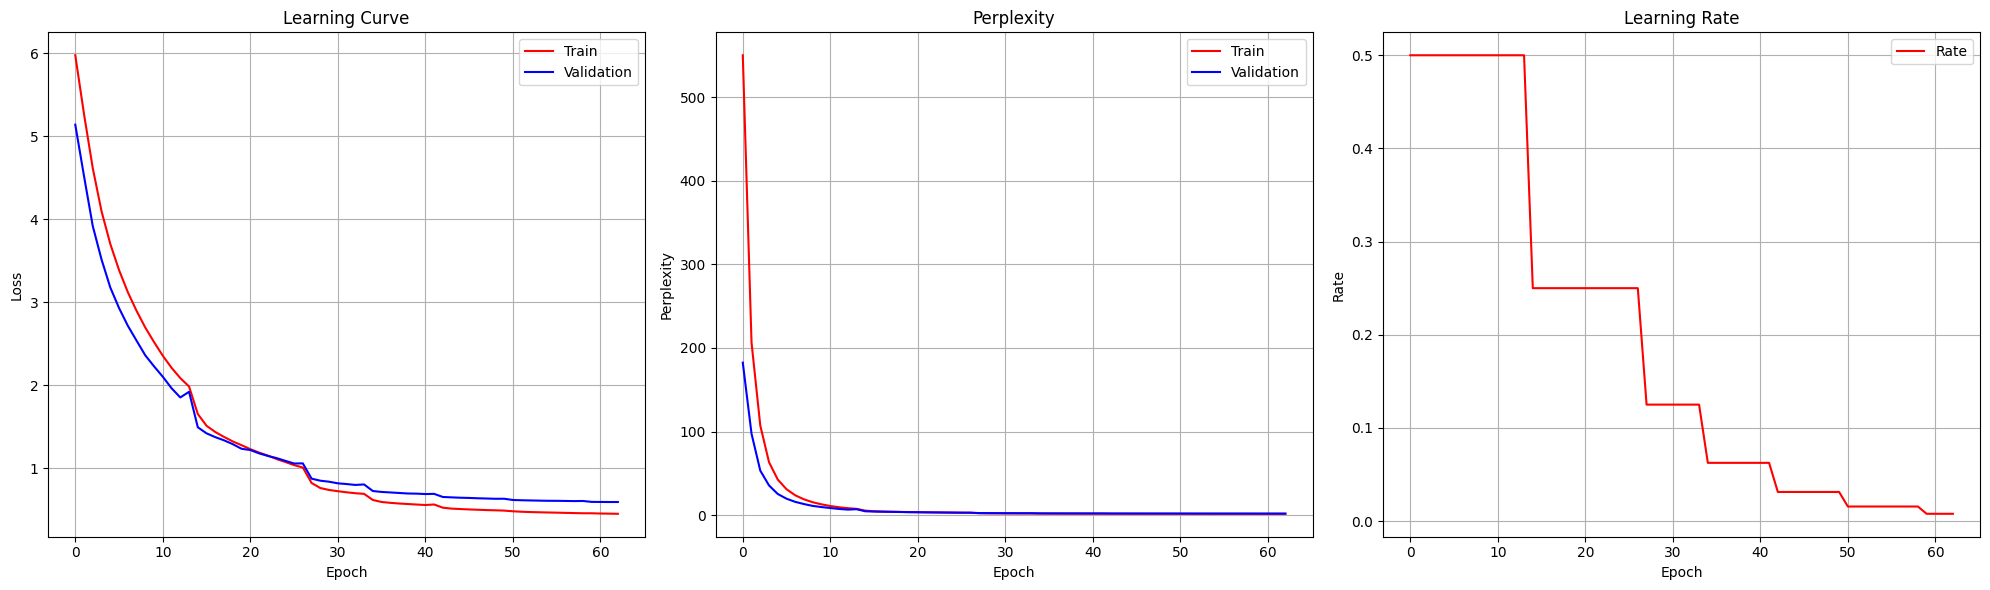

In [19]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 0.594 , Perplexity = 1.826
Test: Loss = 0.5685 , Perplexity = 1.779


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

In [22]:
num_trainable_params(model)

39.309264

In [44]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            #if next_word in ["<eos>", "."]:
            #    break
            del next_token_id
    return generated_text

prompt = "I think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.4, 
                          model = model)

print(generated_text)

I think the movie in large developers in the story , Pat , the brother Hughes also . key is unknown from the movie the series , a new film , and the &lt; unk &gt; , which was &lt; unk &gt; , and the &lt; unk &gt; , &lt; unk &gt; , &lt; unk &gt; , &lt; unk &gt; , &lt; unk &gt; , &lt; unk &gt; , &lt; unk &gt; , &lt; unk &gt; , &lt; unk &gt; , and &lt; unk &gt; , &lt; unk &gt; , &lt; unk &gt; , &lt; unk &gt; , &lt; unk &gt; , &lt; unk
